In [1]:
import re
import os
import joblib
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train_path = "data/train.parquet"
test_path  = "data/test.parquet"

train_df = pd.read_parquet(train_path)
test_df  = pd.read_parquet(test_path)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

# Drop missing
train_df = train_df.dropna(subset=["text", "label"]).copy()
test_df  = test_df.dropna(subset=["text", "label"]).copy()

print("After dropna:")
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)


Train shape: (2936206, 8)
Test shape: (734039, 8)
After dropna:
Train shape: (2936206, 8)
Test shape: (734039, 8)


In [3]:
print("Unique labels:", train_df["label"].nunique())
display(train_df["label"].value_counts())


Unique labels: 3


label
Neutral            1507697
Slightly Biased     831621
Highly Biased       596888
Name: count, dtype: int64

In [4]:
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = text.strip()
    text = re.sub(r"\s+", " ", text)  # collapse whitespace
    return text

X_train = train_df["text"].astype(str).map(clean_text)
y_train = train_df["label"]

X_test  = test_df["text"].astype(str).map(clean_text)
y_test  = test_df["label"]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))
print("Example text:", X_train.iloc[0][:200])


Train samples: 2936206
Test samples: 734039
Example text: http://twitpic.com/6996z - Todays is Katie's birthday. This is what dad got her...(for the weekend


In [5]:
# Word-level TF-IDF (captures terms + phrases like "fake news", "radical left", etc.)
word_tfidf = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    max_features=40000
)

# Character-level TF-IDF (captures style: punctuation, emphasis, casing patterns, short phrases)
char_tfidf = TfidfVectorizer(
    analyzer="char_wb",
    ngram_range=(3, 5),
    min_df=5,
    max_df=0.95,
    max_features=20000
)

model_wc = Pipeline([
    ("features", FeatureUnion([
        ("word", word_tfidf),
        ("char", char_tfidf),
    ])),
    ("clf", LogisticRegression(
        solver="saga",          # multiclass + sparse-friendly
        max_iter=1000,
        class_weight="balanced",
        n_jobs=-1,
        verbose=1
    ))
])

model_wc


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('features', ...), ('clf', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformer_list transformer_list: list of (str, transformer) tuplesList of transformer objects to be applied to the data. The firsthalf of each tuple is the name of the transformer. The transformer canbe 'drop' for it to be ignored or can be 'passthrough' for features tobe passed unchanged... versionadded:: 1.1 Added the option `""passthrough""`... versionchanged:: 0.22 Deprecated `None` as a transformer in favor of 'drop'.","[('word', ...), ('char', ...)]"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"transformer_weights transformer_weights: dict, default=NoneMultiplicative weights for features per transformer.Keys are transformer names, values the weights.Raises ValueError if key not present in ``transformer_list``.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each transformer will beprinted as it is completed.",False
,"verbose_feature_names_out verbose_feature_names_out: bool, default=TrueIf True, :meth:`get_feature_names_out` will prefix all feature nameswith the name of the transformer that generated that feature.If False, :meth:`get_feature_names_out` will not prefix any featurenames and will error if feature names are not unique... versionadded:: 1.5",True
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'


In [6]:
print("Starting training Word+Char TF-IDF model...")
model_wc.fit(X_train, y_train)
print("Training done!")


Starting training Word+Char TF-IDF model...


/Users/akshayprajapati/Desktop/News_Bias/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


Epoch 1, change: 1
Epoch 2, change: 0.11387633
Epoch 3, change: 0.072082481
Epoch 4, change: 0.054395532
Epoch 5, change: 0.043329595
Epoch 6, change: 0.029918551
Epoch 7, change: 0.023611356
Epoch 8, change: 0.017551039
Epoch 9, change: 0.015243222
Epoch 10, change: 0.014357614
Epoch 11, change: 0.0095926396
Epoch 12, change: 0.0066990354
Epoch 13, change: 0.0081038751
Epoch 14, change: 0.0037125552
Epoch 15, change: 0.0030325032
Epoch 16, change: 0.0021884299
Epoch 17, change: 0.0013434448
Epoch 18, change: 0.0014309381
Epoch 19, change: 0.0012952224
Epoch 20, change: 0.00073874438
Epoch 21, change: 0.00049287171
Epoch 22, change: 0.00046220236
Epoch 23, change: 0.00027430232
Epoch 24, change: 0.00035562356
Epoch 25, change: 0.00026277194
Epoch 26, change: 0.00020836362
Epoch 27, change: 0.00010001114
convergence after 28 epochs took 493 seconds
Training done!


In [7]:
y_pred_wc = model_wc.predict(X_test)

acc_wc = accuracy_score(y_test, y_pred_wc)
print("Accuracy (Word+Char):", acc_wc)

print("\nClassification report (Word+Char):")
print(classification_report(y_test, y_pred_wc, digits=4))


Accuracy (Word+Char): 0.8183883962568747

Classification report (Word+Char):
                 precision    recall  f1-score   support

  Highly Biased     0.7894    0.8354    0.8117    148777
        Neutral     0.9202    0.8666    0.8926    377055
Slightly Biased     0.6757    0.7189    0.6966    208207

       accuracy                         0.8184    734039
      macro avg     0.7951    0.8070    0.8003    734039
   weighted avg     0.8244    0.8184    0.8206    734039



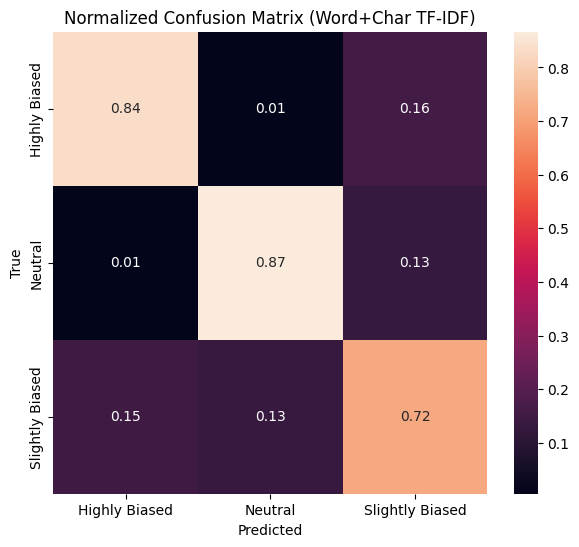

In [8]:
labels = model_wc.named_steps["clf"].classes_
cm = confusion_matrix(y_test, y_pred_wc, labels=labels, normalize="true")

plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Word+Char TF-IDF)")
plt.show()


In [9]:
os.makedirs("models", exist_ok=True)
joblib.dump(model_wc, "models/tfidf_word_char_logreg.joblib")
print("Saved Word+Char model to models/tfidf_word_char_logreg.joblib")


Saved Word+Char model to models/tfidf_word_char_logreg.joblib


In [10]:
loaded_wc = joblib.load("models/tfidf_word_char_logreg.joblib")

sample_text = "The so-called experts claim the policy is a disaster!!!"
pred = loaded_wc.predict([clean_text(sample_text)])[0]

print("Text:", sample_text)
print("Predicted label:", pred)

# top probabilities
probs = loaded_wc.predict_proba([clean_text(sample_text)])[0]
classes = loaded_wc.named_steps["clf"].classes_
top = np.argsort(probs)[::-1][:3]

print("\nTop probabilities:")
for idx in top:
    print(f"  {classes[idx]}: {probs[idx]:.4f}")


Text: The so-called experts claim the policy is a disaster!!!
Predicted label: Highly Biased

Top probabilities:
  Highly Biased: 0.5873
  Slightly Biased: 0.4092
  Neutral: 0.0035
